In [13]:
import torchvision.transforms
import source.data
import source.utils
import torch.hub
import torch.utils.data
import torch
import torch.optim
_  = torch.manual_seed(0)
cpu_device = torch.device('cpu')
device = torch.device('cpu')

In [2]:
image_transform = torchvision.transforms.Compose(
    [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(lambda image_as_int_tensor: image_as_int_tensor / 255.),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((280, 280)),
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.Lambda(
        lambda mask_as_int_tensor: mask_as_int_tensor.squeeze().type(torch.LongTensor)
    ),
])

dataset = source.data.PascalPartSmallDataset(
    transform=image_transform,
    target_transform=mask_transform
)

class View(torch.nn.Module):

    def __init__(self, shape: tuple[int, ...]):
        super().__init__()
        self.shape = shape

    def forward(self, input: torch.Tensor):
        return input.view(-1, *self.shape)

dataloader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=10)

backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

head = torch.nn.Sequential(
    torch.nn.Linear(384, 1225),

    View((1, 35, 35)),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
    torch.nn.ReLU(),

    torch.nn.Upsample(scale_factor=2),
    torch.nn.Conv2d(in_channels=7, out_channels=7, kernel_size=(3, 3), padding=(1, 1)),
)

optimizer = torch.optim.AdamW(head.parameters())
loss_function = torch.nn.NLLLoss()

Using cache found in /Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/vladimir/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [17]:
_ = (
    backbone.to(device),
    loss_function.to(device),
    head.to(device)
)

In [3]:
metrics_tracker: dict[int, list[float]] = {index:[] for index in range(-1, 7)}
n_epochs = 1

for epoch in range(n_epochs):
    for iteration, (images, masks) in enumerate(dataloader):

        images.to(device)
        masks.to(device)

        embeddings = backbone(images)
        logits = head(embeddings)

        log_probabilities = torch.nn.functional.log_softmax(
            logits,
            dim=1, # B x C x H x W
        )

        loss_value = loss_function(
            log_probabilities,
            masks
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=log_probabilities,
            masks=masks,
            classes=list(dataset.class_to_name.keys()),
        )

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        metrics_tracker[-1].append(loss_value.to(cpu_device).detach().item())
        for object_class in list(dataset.class_to_name.keys()):
            metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class].mean().to(cpu_device).detach().item()
            )

        if iteration % 5 == 0:
            print(
                f"Iteration: {epoch * len(dataloader) + iteration}" +
                f"/ {n_epochs*len(dataloader)} "
                f"Loss value: {metrics_tracker[-1][-1]:.3f} \t ",
                "IoU - ",
                *[
                    f"{dataset.class_to_name[object_class]} : " +
                    f"{metrics_tracker[object_class][-1]:.3f} \t "
                    for object_class in list(dataset.class_to_name.keys())
                ]
            )

Iteration: 0/ 10Loss value: 1.945 	  IoU -  bg : 0.015 	  low_hand : 0.073 	  torso : 0.538 	  low_leg : 0.017 	  head : 0.012 	  up_leg : 0.028 	  up_hand : 0.105 	 
Iteration: 5/ 10Loss value: 1.896 	  IoU -  bg : 0.360 	  low_hand : 0.106 	  torso : 0.390 	  low_leg : 0.018 	  head : 0.034 	  up_leg : 0.014 	  up_hand : 0.013 	 


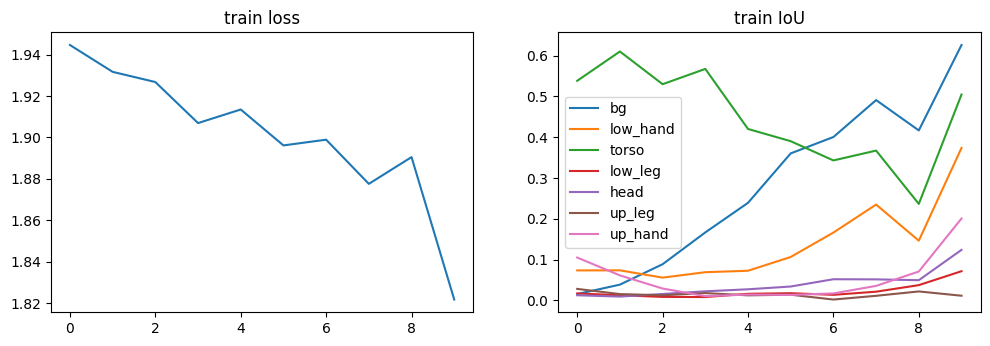

In [4]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(12, 8))

figure.add_subplot(2, 2, 1)
plt.plot(metrics_tracker[-1], label="")
plt.title("train loss")

figure.add_subplot(2, 2, 2)
[
    plt.plot(metrics_tracker[index], label=dataset.class_to_name[index])
    for index in range(0, 7)
]
plt.legend()
plt.title("train IoU")

plt.show()

# metrics on eval

In [5]:
evaluation_dataset = source.data.PascalPartSmallDataset(
    transform=image_transform,
    train=False,
)
_ = backbone.eval(), head.eval()
evaluation_metrics_tracker = {index:[] for index in range(0, 7)}

In [6]:
with torch.no_grad():
    for image, mask in evaluation_dataset:
        image.to(device)
        mask.to(device)
        
        mask_shape = mask.shape
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        embedding = backbone(image)
        logits = head(embedding)

        log_probabilities = torch.nn.functional.log_softmax(
            logits,
            dim=1, # 1 x C x H x W
        )
        upsampled_log_probabilities = torch.nn.functional.interpolate(
            input=log_probabilities,
            size=mask_shape,
        )

        intersection_over_union_per_class = source.utils.log_probabilities_and_mask_iou_per_class(
            log_probabilities=upsampled_log_probabilities,
            masks=mask,
            classes=list(dataset.class_to_name.keys()),
        )
        
        for object_class in list(dataset.class_to_name.keys()):
            evaluation_metrics_tracker[object_class].append(
                intersection_over_union_per_class[object_class].mean().to(cpu_device).item()
            )

print(
    "IoU - ",
    *[
        f"{evaluation_dataset.class_to_name[object_class]} : " +
        f"{sum(evaluation_metrics_tracker[object_class]) / len(evaluation_metrics_tracker[object_class]):.3f} \t "
        for object_class in list(evaluation_dataset.class_to_name.keys())
    ]
)

IoU -  bg : 0.670 	  low_hand : 0.674 	  torso : 0.591 	  low_leg : 0.235 	  head : 0.212 	  up_leg : 0.016 	  up_hand : 0.298 	 


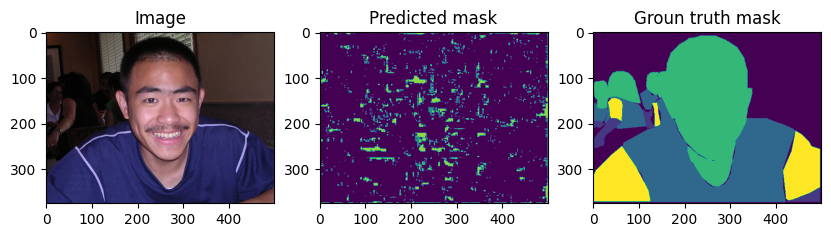

In [11]:
random_index = torch.randint(0, len(evaluation_dataset), size=(1, )).item()
original_image, original_mask = source.data.PascalPartSmallDataset(train=False)[random_index]
mask_shape = original_mask.shape
image = image_transform(original_image).unsqueeze(0)
mask = mask.unsqueeze(0)

image.to(device)
embedding = backbone(image)
logits = head(embedding)

log_probabilities = torch.nn.functional.log_softmax(
    logits,
    dim=1, # 1 x C x H x W
)
upsampled_log_probabilities = torch.nn.functional.interpolate(
    input=log_probabilities,
    size=mask_shape,
)
predicted_mask = upsampled_log_probabilities.argmax(
    dim=1
).squeeze().to(cpu_device)

figure = plt.figure(figsize=(10, 4))

figure.add_subplot(1, 3, 1)
plt.imshow(original_image.squeeze().permute(1, 2, 0))
plt.title("Image")

figure.add_subplot(1, 3, 2)
plt.imshow(predicted_mask)
plt.title("Predicted mask")

figure.add_subplot(1, 3, 3)
plt.imshow(original_mask.squeeze())
plt.title("Groun truth mask")


plt.show()